In [7]:
import os
import numpy as np
import xarray as xr

import pygmt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['contour.negative_linestyle']= 'solid'
import cmocean

In [8]:
from tools.config import OPSAREA, MAPEXTENT

In [9]:
# figure settings
figdir  = 'img/'
filename = 'SMODE_OperationsArea'
extension = ['png','pdf']
figproperties = dict(dpi=200,bbox_inches='tight')

### [pygmt](https://www.pygmt.org/v0.2.1/index.html): postscript GMT figure

Somewhat cryptic syntax but gorgeous maps. Requires GMT 6 in addition to pygmt.

In [10]:
# Settings
topo_data = '@earth_relief_30s'
proj = 'M6i'

In [11]:
# Make the figure
fig = pygmt.Figure()

# High-res topography
pygmt.makecpt(
    cmap='bathy',
    series='-7010/-10/10',
    continuous=True
)

fig.grdimage(
    grid=topo_data,
    region=MAPEXTENT,
    projection=proj,
    shading=True,
    frame="ag"
    )


fig.grdcontour(
    grid=topo_data,
    interval=100,
    annotation="100+f6p",
    limit="-210/-10",
    pen="a0.15p",
    )

fig.grdcontour(
    grid=topo_data,
    interval=1000,
    annotation="1000+f6p",
    limit="-5000/-1000",
    pen="a0.15p",
    )


# Operations area
fig.plot(
    x=OPSAREA['longitude'],
    y=OPSAREA['latitude'],
    color='gray30@40',
    pen='3p,black',
    )

# Coast
fig.coast(
    shorelines=True,
    resolution='f',land='black')

# Legends and text
fig.text(
    x=[-123.85],
    y=[37.2],
    text='S-MODE Operations Area',  
    font='11p,Helvetica-Bold,white',
    angle=27,
    )

fig.show()

# To save in extensions other than ps, eps or pdf, you will need psconvet 
# installed
# [fig.savefig(os.path.join(figdir,filename+'_gmt.'+ext),
#              **figproperties) 
#              for ext in extension]
fig.savefig(os.path.join(figdir,filename+'_gmt.pdf'))

   **** WARNING: .setopacityalpha is deprecated (as of 9.53.0) and will be removed in a future release
   **** See .setfillconstantalpha/.setalphaisshape for the improved solution
   **** WARNING: .setopacityalpha is deprecated (as of 9.53.0) and will be removed in a future release
   **** See .setfillconstantalpha/.setalphaisshape for the improved solution


In [12]:
# !open -a Preview img/SMODE_OperationsArea_gmt.pdf  # this only works on the Mac

### [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html)
A bit more intuitive (but clunky) syntax and decent-looking maps. Maps could be beautified, but that takes a lot of work.

The old NaturalEarth server is broken (9/22/2021). Features may have to manually downloaded and unzipped (see https://github.com/SciTools/cartopy/issues/1849).

In [13]:
# Get slice of ETOPO1 data from WHOI's GEOPORT thredds
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bathy = xr.open_dataset(url)
bathy = bathy.sel(lon=slice(MAPEXTENT[0],MAPEXTENT[1]),
                  lat=slice(MAPEXTENT[2],MAPEXTENT[3])
)

In [16]:
projection = ccrs.PlateCarree(central_longitude=(MAPEXTENT[0]+MAPEXTENT[1])/2)
map_axes = (GeoAxes,{'map_projection':projection})

In [17]:
# A simple modified version of the functions below
# may come in handy for any mesoscale/large-scale
# map one wishes to plot in the SMODE region

def plot_operations_area(ax,
                         transform=None,
                         add_label=False):
    
    """
        Plot S-MODE opeations area. 
        TODO: finish this docstring, adding a complete
              description of parameters.
    """
    
    kwargs_plot = dict(color='k',linewidth=4)
    kwargs_fill = dict(color='0.5', alpha=0.6)
    
    if transform:
        kwargs_plot['transform'] = transform
        kwargs_fill['transform'] = transform
                       
    
    ax.plot(OPSAREA['longitude'],
            OPSAREA['latitude'],
            **kwargs_plot
       )

    ax.fill(OPSAREA['longitude'],
            OPSAREA['latitude'],
            transform=transform,
            **kwargs_fill
           )

    if add_label:
        ax.text(-124.69, 36.9, 
                'S-MODE Operations Area',
                color='w',
                fontsize=11,
                fontweight='bold',
                rotation=22,
                transform=transform,
               )
        
def plot_topography(ax,
                    transform=None):    
    """
        Plot S-MODE opeations area. 
        TODO: finish this docstring, adding a complete
              description of parameters.
    """

    bathy['topo'].plot.pcolormesh(ax=ax,vmin=-5020,vmax=0,
                                  add_colorbar=False, shading='flat',
                                  extend='neither',cmap='Blues_r',
                                  transform=transform
    )


    clevels = [-5000,-4000,-3000,-2000,-1000,-200,-100]
    CS = bathy['topo'].plot.contour(ax=ax,levels=clevels,
                                    colors='k',linewidths=1,
                                     transform=transform
    )

    ax.clabel(CS, CS.levels, inline=True, fmt='%i', fontsize=10)

    
def plot_map_properties(ax,
                        transform=None):
    """
            TODO: write docstring
    """
    
    # Axis labels
    ax.set_yticks(np.arange(36,40,1), crs=transform)
    ax.set_xticks(np.arange(-126,-120,1), crs=transform)

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel('')
    ax.set_ylabel('')


    # Continent
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                   edgecolor='face', facecolor='0.1')
    )

    # Gridlines
    gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='-')
    gl.xlocator = mticker.FixedLocator(np.arange(-126,-120,1))
    gl.ylocator = mticker.FixedLocator(np.arange(36,40,1))

TypeError: matplotlib.axes._axes.Axes.fill() got multiple values for keyword argument 'transform'

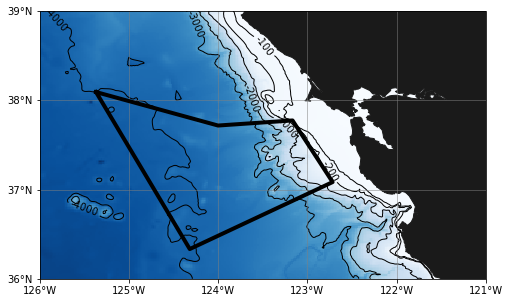

In [19]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111, projection=projection)     

ax.set_extent(MAPEXTENT)

# Topography
plot_topography(ax, transform=ccrs.PlateCarree())

# Map properties (continent, labels, grid)
plot_map_properties(ax,transform=ccrs.PlateCarree())

# SMODE area
plot_operations_area(ax=ax,
                     transform=ccrs.PlateCarree(),
                     add_label=True
)

# Save figure
[fig.savefig(os.path.join(figdir,filename+'_cartopy.'+ext),
             **figproperties) 
            for ext in extension]